In [1]:
#basic libraries
import h2o
import numpy as np
import pandas as pd
import re
import joblib

#helper function
import helper

#scikit-learn libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import KNNImputer

#h2o models and grid search
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.grid.grid_search import H2OGridSearch

#plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

#XGBoost
from xgboost import XGBClassifier

#model explainability
import shap

%matplotlib inline

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Feature engineering and feature selection
After getting the base model scores on the previous notebook, I will try to improve those scores on this notebook. I will take feature engineering and feature selection approach to do this.

The data that I'm going to use is the non_standardized_data.csv from the previous 2 notebooks since I don't want standardized values yet for these models. Instead, I will create the features first, select relevant features, and then standardize those features.

In [2]:
df = pd.read_csv('data/non_standardized_data.csv')

In [3]:
df.head()

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
0,0000757f-a121-41ed-b17b-162e76647c1f,dde79588-12f0-4811-bab0-e2b07f633fcd,loan_given,11731.0,0,746.0,4.0,rent,50025.0,debt_consolidation,355.18,11.5,28.4,12,0,17391,37081.0,0.0,0.0
1,0000afa6-8902-4f8f-b870-25a8fdad0aeb,e49c1a82-a0f7-45e8-9f46-2f75c43f9fbc,loan_refused,24613.0,1,744.8,6.0,rent,95414.0,business_loan,542.29,17.6,73.0,7,0,14123,16954.0,0.0,0.0
2,00020fb0-6b8a-4b3a-8c72-9c4c847e8cb6,c9decd06-16f7-44c3-b007-8776f2a9233d,loan_given,19018.4,0,742.0,3.0,home_mortgage,64760.0,debt_consolidation,582.84,26.8,23.2,11,0,8880,22711.0,0.0,0.0
3,00045ecd-59e9-4752-ba0d-679ff71692b3,b7bce684-b4b0-4b29-af66-eae316bce573,loan_given,11863.0,0,734.0,10.0,own_home,69202.0,debt_consolidation,859.26,30.3,33.2,7,0,9959,16995.0,0.0,0.0
4,0004f37b-5859-40f6-98d0-367aa3b3f3f1,f662b062-5fa5-463d-b5c0-4e36d09fcab1,loan_given,13719.0,0,724.0,1.0,own_home,34297.0,home_improvements,777.38,13.6,2.0,12,0,6720,53335.0,0.0,0.0


In [4]:
df.drop(['loan_id', 'customer_id'], axis = 1, inplace = True)

In [5]:
df.purpose.value_counts()

purpose
debt_consolidation      70446
other                    7767
home_improvements        5205
business_loan            1328
buy_a_car                1196
medical_bills             955
buy_house                 559
take_a_trip               454
major_purchase            344
small_business            248
moving                    124
wedding                    99
educational_expenses       92
vacation                   82
renewable_energy            9
Name: count, dtype: int64

1. Debt consolidation
2. Business loans
3. Personal loans
4. Other

Now that I've done a basic data preprocessing, I will start to engineer some features from the dataset. 


## First experiment: Eliminating multicolinearity problems.
My approach in engineering these features for the first experiment is by eliminating the multicolinearity problems found in the 2nd notebook, and simplifying some columns. By doing those, I hope that I can increase the model performances and eventually select the best model to make the predictions.  

Below is the outline of what I'm going to do during this phase:
1. Simplify the purpose column. Judging from the feature importances from the previous notebook, the values in this column doesn't add much to the models' prediction power. It might be because there are too many unique values in it. Therefore, I will map these values into debt consolidation, business loans, personal loans, and other. 
2. Create debt_equity_ratio. This feature is derived from dividing monthly debt and annual income. This is because I don't have the net worth/equity data for each of the applicants, so the annual income becomes the proxy of equity. Also, although the correlation between these 2 variables is not greater than 0.5, it came quite close (0.47). 
3. Create credit_utilization_ratio column. This feature represents the percentage of a person's available credit that they are currently using. The values will be calculated by dividing current_credit_balance with maximum_open_credit. A high credit utilization ratio indicates that borrowers use most of their available credit and thus indicates high financial stress. This will also solve the high correlation between these 2 variables.
4. Simplify months_since_last_delinquent and years_in_current_job columns into is_months_delinquent missing which indicates whether a borrower were late in repaying the debt, and has_stable_job which indicates whether a borrower has a stable job or not judging by how many years the borrower has been working in the current company.

### Dealing with purpose column

In [6]:
purpose_mapping = {
    'debt_consolidation': 'debt_consolidation',
    'business_loan': 'business_loans',
    'small_business': 'business_loans',
    'other': 'other',
    'home_improvements': 'personal_loans',
    'buy_a_car': 'personal_loans',
    'medical_bills': 'personal_loans',
    'buy_house': 'personal_loans',
    'take_a_trip': 'personal_loans',
    'major_purchase': 'personal_loans',
    'moving': 'personal_loans',
    'wedding': 'personal_loans',
    'educational_expenses': 'personal_loans',
    'vacation': 'personal_loans',
    'renewable_energy': 'personal_loans',
}

df.replace({"purpose": purpose_mapping}, inplace=True)

df.purpose.value_counts()

purpose
debt_consolidation    70446
personal_loans         9119
other                  7767
business_loans         1576
Name: count, dtype: int64

In [7]:
df.head()

,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
0,loan_given,11731.0,0,746.0,4.0,rent,50025.0,debt_consolidation,355.18,11.5,28.4,12,0,17391,37081.0,0.0,0.0
1,loan_refused,24613.0,1,744.8,6.0,rent,95414.0,business_loans,542.29,17.6,73.0,7,0,14123,16954.0,0.0,0.0
2,loan_given,19018.4,0,742.0,3.0,home_mortgage,64760.0,debt_consolidation,582.84,26.8,23.2,11,0,8880,22711.0,0.0,0.0
3,loan_given,11863.0,0,734.0,10.0,own_home,69202.0,debt_consolidation,859.26,30.3,33.2,7,0,9959,16995.0,0.0,0.0
4,loan_given,13719.0,0,724.0,1.0,own_home,34297.0,personal_loans,777.38,13.6,2.0,12,0,6720,53335.0,0.0,0.0


### Create new features
After creating the new features, I will drop the columns used in creating them, and bankruptcies and tax_liens columns. I'm dropping these 2 columns because of their distributions (a lot more 0 than other values) and the multicolinearity problems caused by these columns.

In [8]:
df['debt_equity_ratio'] = df['monthly_debt'] / df['annual_income']
df['credit_utilization_ratio'] = df['current_credit_balance'] / df['maximum_open_credit']
df['is_months_delinquent_missing'] = df['months_since_last_delinquent'].isnull().astype(int)
df['has_stable_job'] = (df['years_in_current_job'] > 2).astype(int)

In [9]:
#copy the dataframe into df_feature to use in the next experiment
df_feature = df.copy()

#dropping unnecessary columns
df.drop(['bankruptcies', 'monthly_debt', 'annual_income', 'current_credit_balance', 'years_in_current_job', 'maximum_open_credit', 'months_since_last_delinquent', 'tax_liens'], axis = 1, inplace = True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88908 entries, 0 to 88907
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   loan_status                   88908 non-null  object 
 1   current_loan_amount           88908 non-null  float64
 2   term                          88908 non-null  int64  
 3   credit_score                  88908 non-null  float64
 4   home_ownership                88908 non-null  object 
 5   purpose                       88908 non-null  object 
 6   years_of_credit_history       88908 non-null  float64
 7   number_of_open_accounts       88908 non-null  int64  
 8   number_of_credit_problems     88908 non-null  int64  
 9   debt_equity_ratio             88908 non-null  float64
 10  credit_utilization_ratio      88397 non-null  float64
 11  is_months_delinquent_missing  88908 non-null  int32  
 12  has_stable_job                88908 non-null  int32  
dtypes

In [11]:
#checking for missing values
df.isnull().sum()

loan_status                       0
current_loan_amount               0
term                              0
credit_score                      0
home_ownership                    0
purpose                           0
years_of_credit_history           0
number_of_open_accounts           0
number_of_credit_problems         0
debt_equity_ratio                 0
credit_utilization_ratio        511
is_months_delinquent_missing      0
has_stable_job                    0
dtype: int64

There are still some missing values in the credit_utilization_ratio, mostly because there are division by zero problems resulting in infinity values. I will impute the missing values using KNN Imputer, the same as the previous notebook. 

In [12]:
#impute using KNNImputer
imputer = KNNImputer(n_neighbors=5)
column_names_to_impute = ['credit_utilization_ratio']
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=column_names_to_impute)
imputed = imputer.fit_transform(df[column_names_to_impute].values)

joblib.dump(imputer, 'model/knn_imputer_model_no_multicol.pkl')

data_temp = pd.DataFrame(imputed, columns=column_names_to_impute, index = df.index)
df[column_names_to_impute] = data_temp

#sanity checking
df.isnull().sum()

loan_status                     0
current_loan_amount             0
term                            0
credit_score                    0
home_ownership                  0
purpose                         0
years_of_credit_history         0
number_of_open_accounts         0
number_of_credit_problems       0
debt_equity_ratio               0
credit_utilization_ratio        0
is_months_delinquent_missing    0
has_stable_job                  0
dtype: int64

Now that the missing values are imputed, I will create a correlation matrix heatmap to make sure that the multicolinearity problems are dealt with.

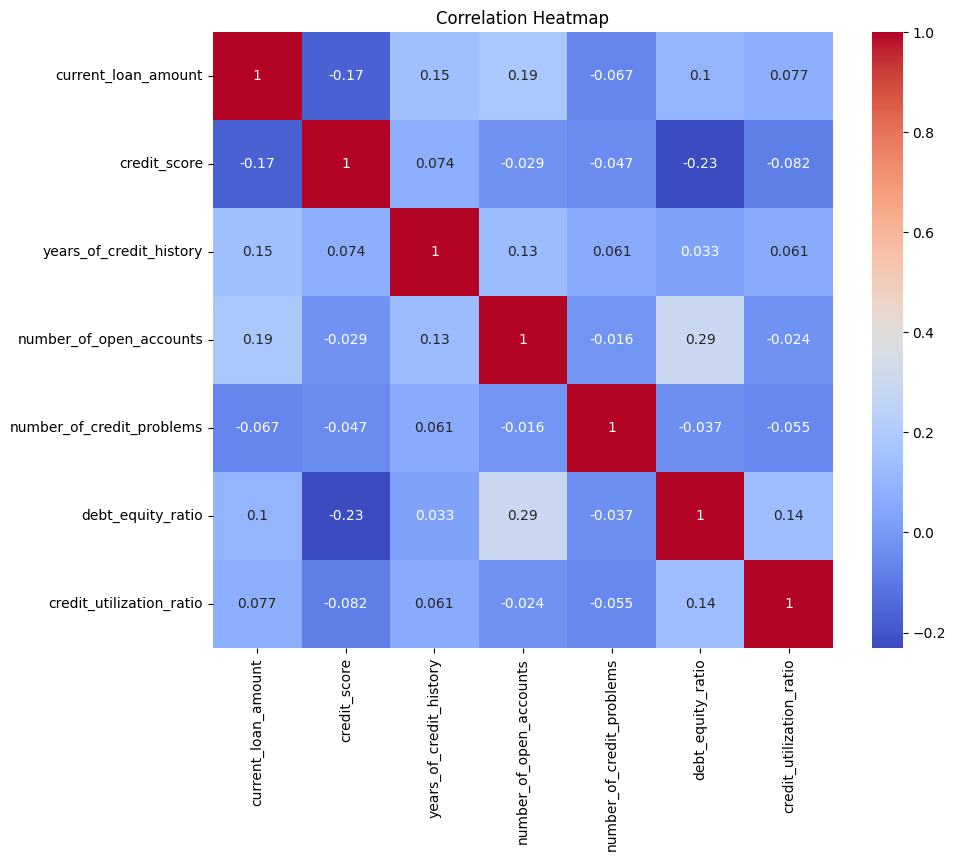

In [13]:
corr_matrix = df[['current_loan_amount', 'credit_score', 'years_of_credit_history', 'number_of_open_accounts', 'number_of_credit_problems', 'debt_equity_ratio', 'credit_utilization_ratio']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show();

There are no correlation values greater than 0.5, so it's safe to assume that multicolinearity is no longer a problem here. Next, I will do one-hot-encodings for "purpose" and "home_ownership" columns.

In [14]:
#create dummies variable (one hot encode)
dummies = pd.get_dummies(df['purpose'], prefix='purpose', drop_first = True)
df[dummies.columns] = dummies

dummies = pd.get_dummies(df['home_ownership'], prefix='home', drop_first = True)
df[dummies.columns] = dummies

df = df.drop(["home_ownership", "purpose"], axis=1)
df = df.replace({True: 1, False: 0})

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88298 entries, 0 to 88907
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   loan_status                   88298 non-null  object 
 1   current_loan_amount           88298 non-null  float64
 2   term                          88298 non-null  int64  
 3   credit_score                  88298 non-null  float64
 4   years_of_credit_history       88298 non-null  float64
 5   number_of_open_accounts       88298 non-null  int64  
 6   number_of_credit_problems     88298 non-null  int64  
 7   debt_equity_ratio             88298 non-null  float64
 8   credit_utilization_ratio      88298 non-null  float64
 9   is_months_delinquent_missing  88298 non-null  int32  
 10  has_stable_job                88298 non-null  int32  
 11  purpose_debt_consolidation    88298 non-null  int64  
 12  purpose_other                 88298 non-null  int64  
 13  purpos

Next, I will continue with standardizing the numeric values for the dataset. I will not standardize the binary and ratio columns.

In [16]:
cols_to_standardize = ['current_loan_amount', 'credit_score', 'years_of_credit_history', 'number_of_open_accounts', 'number_of_credit_problems']
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df[cols_to_standardize].values)

data_temp = pd.DataFrame(data_scaled, columns=cols_to_standardize, index = df.index)
df[cols_to_standardize] = data_temp

In [17]:
#save the scaler
scaler_filename = 'model/scaler_no_multicol.pkl'
joblib.dump(scaler, scaler_filename)

['model/scaler_no_multicol.pkl']

Now, the data is ready and I will continue with the model training phase.

In [18]:
df.to_csv('data/final_data_engineered.csv', index = False)

## Model Training
After finishing the feature engineering, feature selection, and standardize the data, I will continue with model training. The steps are similar to the previous notebook. I saved all the training functions and metrics calculation functions in the file helper.py to make sure that the training phase in the experiment is exactly the same as the one in the baseline models creation. 

I will begin by initializing H2O, parsing the dataframe I used into H2O dataframe, assigning predictors and response columns, and splitting the data into train, test, and val.

In [19]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.8+9-LTS-211, mixed mode, sharing)
  Starting server from C:\Users\agust\Anaconda3\envs\h2o_loan_classification\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\agust\AppData\Local\Temp\tmph3prdt0b
  JVM stdout: C:\Users\agust\AppData\Local\Temp\tmph3prdt0b\h2o_agust_started_from_python.out
  JVM stderr: C:\Users\agust\AppData\Local\Temp\tmph3prdt0b\h2o_agust_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Asia/Jakarta
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.2
H2O_cluster_version_age:,1 month and 19 days
H2O_cluster_name:,H2O_from_python_agust_46vlwg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.854 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [20]:
#parsing the dataframe to H2O dataframe
hf = h2o.H2OFrame(df)

#separating predictors and response
predictors = list(df.columns[1:])
response = "loan_status"

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [21]:
#create train, test, and validation dataset
train_temp, test = hf.split_frame(ratios = [.8], seed = 42)
train, val = train_temp.split_frame(ratios = [.8], seed = 42)

### H2O Gradient Boosting Model
The first model to train is the gradient boosting model. The hyperparameters to tune are the same as the previous notebook to make it a fair comparison. 

In [22]:
#hyperparameters to tune
learn_rate = [0.01, 0.05, 0.1]
max_depth = [5, 7, 9]
ntrees = [300, 500, 700]
sample_rate = [0.5, 0.8, 1.0]
col_sample_rate = [0.25, 0.5, 1.0]

#train the model
best_gbm1, gbm_perf, gbm_gridperf1 = helper.train_gbm_h2o(predictors, response, train, test, val, learn_rate, max_depth, ntrees, sample_rate, col_sample_rate)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


In [23]:
gbm_gridperf1

,col_sample_rate,learn_rate,max_depth,ntrees,sample_rate,model_ids,aucpr
,1.0,0.01,7.0,700.0,0.8,gbm_grid1_model_147,0.4609114
,1.0,0.01,7.0,700.0,0.5,gbm_grid1_model_66,0.4605907
,1.0,0.05,5.0,500.0,0.8,gbm_grid1_model_114,0.4605097
,1.0,0.05,5.0,700.0,0.8,gbm_grid1_model_141,0.4605097
,1.0,0.05,5.0,300.0,0.8,gbm_grid1_model_87,0.4605097
,1.0,0.01,7.0,500.0,0.8,gbm_grid1_model_120,0.4601493
,0.5,0.05,5.0,500.0,0.8,gbm_grid1_model_113,0.4601478
,0.5,0.05,5.0,700.0,0.8,gbm_grid1_model_140,0.4601478
,0.5,0.05,5.0,300.0,1.0,gbm_grid1_model_167,0.4601291
,0.5,0.05,5.0,500.0,1.0,gbm_grid1_model_194,0.4601291


In [24]:
print(gbm_perf)

ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.18538822861257695
RMSE: 0.43056733342483955
LogLoss: 0.5518808406349871
Mean Per-Class Error: 0.3838995824700379
AUC: 0.6759952759884089
AUCPR: 0.46548395191547687
Gini: 0.35199055197681783

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23015043760183435
              loan_given    loan_refused    Error    Rate
------------  ------------  --------------  -------  ----------------
loan_given    5687          6996            0.5516   (6996.0/12683.0)
loan_refused  1084          3930            0.2162   (1084.0/5014.0)
Total         6771          10926           0.4566   (8080.0/17697.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.23015      0.493099  271
max f2                       0.125352     0.674937  351
max f0point5                 0.365044     0.4

#### Model Summary
The model summary is as follows:

In [27]:
f1_gbm, precision_gbm, recall_gbm, auc_gbm = helper.calculate_metrics_summary(gbm_perf, df, 'GBM')

The F1 score for GBM is 0.7387352921302904
The precision score for GBM is 0.9838040754588955
The recall score for GBM is 0.7281700026330532
The AUC score for GBM is 0.6759952759884089


The key takeaways from the model summary are:
1. The F1 score indicates that the model can achieve a somewhat good balance between making correct positive predictions and capturing positive instances. The F1 score increases compared to the base model.
2. Based on the precision score, this model is able to predict 98.38% approved loans when the loans are supposed to be approved. This is a good score for the model, and also the precision score improves from the base model, although the improvement is very little.
3. Based on the recall score, this model can recognize 72.72% of all eligible loan applicants. This is also an improvement, although it's very little.
4. The AUC score indicates that the model's power to discriminate between positive and negative cases (loan given and loan refused) is somewhat good. The score decreases compared to the base model.

In [28]:
#saving model
model_path = h2o.save_model(
  best_gbm1,
  path = "model",
  force = True,
  export_cross_validation_predictions = False
)
model_path

'C:\\Online Course\\Projects\\loan-classification-h20-xgboost\\model\\gbm_grid1_model_147'

### Using H2O Deep Learning
Next, I will repeat the training process using deep learning from H2O library. Again, the hyperparameters to tune are the same as the previous notebook. 

In [29]:
hidden = [[16, 16], [16, 32, 64], [16, 32, 64, 128]]
epochs = [50, 100, 200]
balance_classes = [True, False]
activation = ['Rectifier', 'Tanh', 'RectifierWithDropout','Maxout']
best_dl_model, dl_perf = helper.train_dl_h2o(predictors, response, train, test, val, hidden, epochs, balance_classes, activation)

deeplearning Grid Build progress: |██████████████████████████████████████████████| (done) 100%


In [30]:
print(dl_perf)

ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.18853601461473812
RMSE: 0.4342073405813611
LogLoss: 0.5604730932510338
Mean Per-Class Error: 0.4009184045769378
AUC: 0.6611479499756592
AUCPR: 0.4444374682822319
Gini: 0.32229589995131835

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23980789615678788
              loan_given    loan_refused    Error    Rate
------------  ------------  --------------  -------  ----------------
loan_given    5101          7582            0.5978   (7582.0/12683.0)
loan_refused  1023          3991            0.204    (1023.0/5014.0)
Total         6124          11573           0.4862   (8605.0/17697.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.239808     0.48122   280
max f2                       0.126067     0.670528  375
max f0point5                 0.338874 

#### Model Summary
The model summary is as follows:

In [32]:
f1_dl, precision_dl, recall_dl, auc_dl = helper.calculate_metrics_summary(dl_perf, df, 'Deep Learning')

The F1 score for Deep Learning is 0.7662106784318446
The precision score for Deep Learning is 0.9267489806700677
The recall score for Deep Learning is 0.7447449160571441
The AUC score for Deep Learning is 0.6611479499756592


The key takeaways from the model summary are:
1. The F1 score indicates that the model can achieve a somewhat good balance between making correct positive predictions and capturing positive instances. I can improve the F1 score by quite a high number.
2. Based on the precision score, this model is able to predict 92.67% approved loans when the loans are supposed to be approved. This is a good score for the model. However, the precision score dropped significantly from 0.9984 to 0.9267.
3. Based on the recall score, this model can recognize 74.47% of all eligible loan applicants. This is also an increase from the base model.
4. The AUC score indicates that the model's power to discriminate between positive and negative cases (loan given and loan refused) good, although it can be improved more. However, this score also dropped from 0.678 to 0.6611

In [33]:
#saving model
model_path = h2o.save_model(
  best_dl_model,
  path = "model",
  force = True,
  export_cross_validation_predictions = False
)
model_path

'C:\\Online Course\\Projects\\loan-classification-h20-xgboost\\model\\dl_grid_model_66'

### Using XGBoost
The last model in this experiment is the XGBoost model. Again, the hyperparameters to tune is the same as the previous notebook. 

In [34]:
n_estimators = [100, 200, 300]
max_depth = [3, 4, 5]
subsample = [0.8, 0.9, 1.0]
reg_alpha = [0.1, 0.5, 0.8]
reg_lambda = [0.1, 0.5, 0.8]
learning_rate = [0.1, 0.01]
max_bin = [128, 256, 512]

best_xgb_model, X_test, y_test = helper.train_xgboost(df, n_estimators, max_depth, subsample, reg_alpha, reg_lambda, learning_rate, max_bin)

The number of training dataset is 56510, the number of validation dataset is 14128, and the number of testing dataset is 17660.
Training the model...
Fitting 3 folds for each of 1458 candidates, totalling 4374 fits
DONE!
Best Parameters: {'learning_rate': 0.1, 'max_bin': 128, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0.8, 'reg_lambda': 0.5, 'subsample': 0.9}


#### Model Summary
The model summary is as follows:

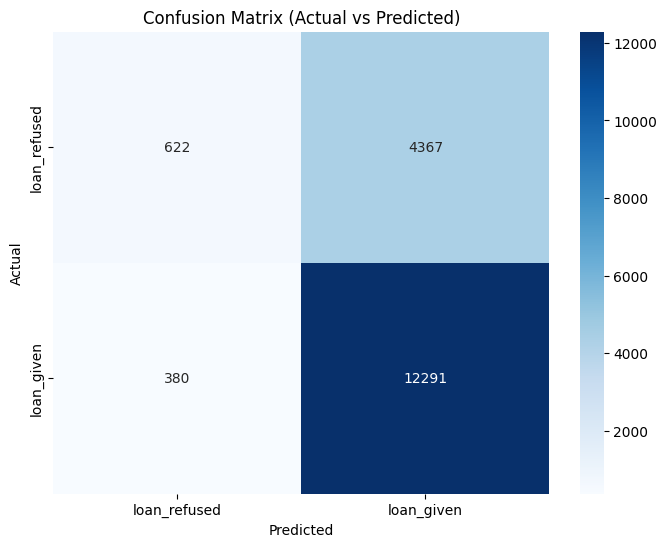

The F1 score for XGBoost is 0.6600280166280574
The precision score for XGBoost is 0.7047667794353247
The recall score for XGBoost is 0.7312004530011325
The AUC score for XGBoost is 0.5473422715357734


In [41]:
f1_xgb, precision_xgb, recall_xgb, auc_xgb = calculate_model_metrics_xgboost(best_xgb_model, X_test, y_test, "XGBoost")

The key takeaways from the model summary are:
1. The F1 score indicates that the model can achieve a somewhat good balance between making correct positive predictions and capturing positive instances. 
2. Based on the precision score, this model is able to predict 71.39% approved loans when the loans are supposed to be approved. This is a good score for the model.
3. Based on the recall score, this model can recognize 73.6% of all eligible loan applicants. Although this number is considerably good, this means that the business has the chance of losing 27.28% eligible loan applicants.
4. The AUC score indicates that the model's power to discriminate between positive and negative cases (loan given and loan refused) not too good. It's too close to 0.5 which indicates that the model is closer to a random guess than an accurate prediction.

In [43]:
#saving the model
joblib.dump(best_xgb_model, 'model/best_xgb_model_no_multicol.pkl')

['model/best_xgb_model_no_multicol.pkl']

### Comparisons between 3 models
The next step is to compare the performance of the 3 models in this experiment. The metrics I'm going to compare is still the weighted F1 scores, weighted precision scores, weighted recall scores, and AUC scores. 

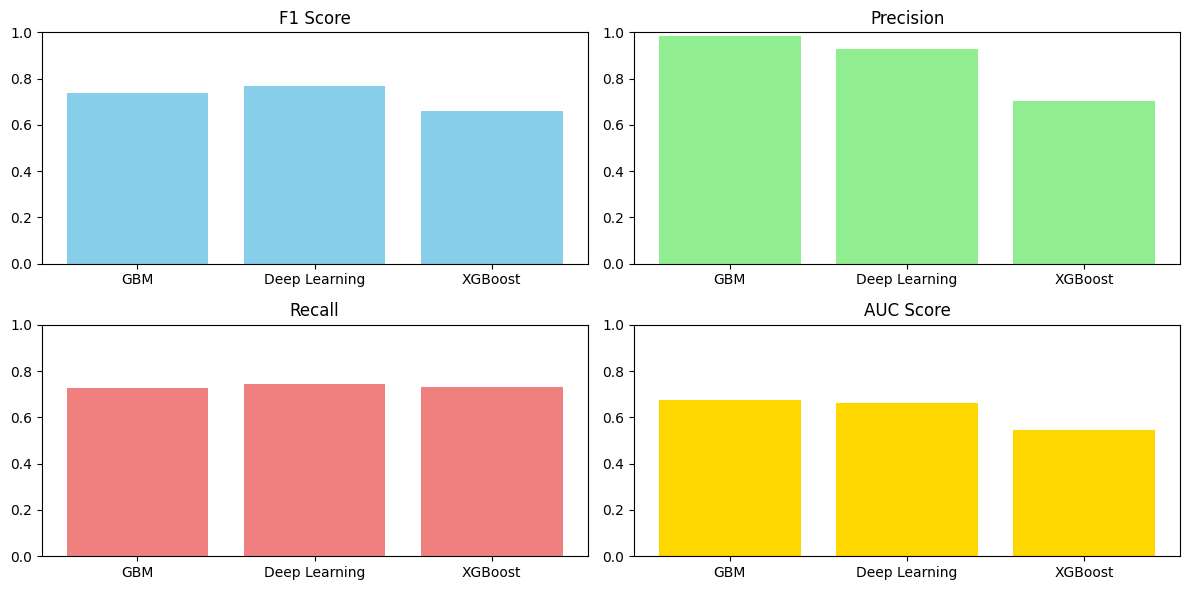

In [44]:
models = ['GBM', 'Deep Learning', 'XGBoost']
f1_scores = [f1_gbm, f1_dl, f1_xgb]
precision_scores = [precision_gbm, precision_dl, precision_xgb]
recall_scores = [recall_gbm, recall_dl, recall_xgb]
auc_scores = [auc_gbm, auc_dl, auc_xgb]
scores_df = helper.compare_score(f1_scores, precision_scores, recall_scores, auc_scores, models)

In [45]:
scores_df

,Model,F1 Score,Precision,Recall,AUC Score
0,GBM,0.738735,0.983804,0.728170,0.675995
1,Deep Learning,0.766211,0.926749,0.744745,0.661148
2,XGBoost,0.660028,0.704767,0.731200,0.547342


In [46]:
scores_df.to_csv('data/no_multicol_model_scores.csv', index = False)

## Experiment 2: Using all features
In the second experiment, I will do similar stuff with the first one. However, in this experiment, I will use both the original and engineered features. While this will definitely have multicolinearity problems, I want to see whether it's okay to sacrifice interpretability for better model performance.

The dataframe I will use is df_feature which was copied from the original dataframe (df) previously.

In [47]:
df_feature.head()

,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,...,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens,debt_equity_ratio,credit_utilization_ratio,is_months_delinquent_missing,has_stable_job
0,loan_given,11731.0,0,746.0,4.0,rent,50025.0,debt_consolidation,355.18,11.5,...,12,0,17391,37081.0,0.0,0.0,0.007100,0.469000,0,1
1,loan_refused,24613.0,1,744.8,6.0,rent,95414.0,business_loans,542.29,17.6,...,7,0,14123,16954.0,0.0,0.0,0.005684,0.833019,0,1
2,loan_given,19018.4,0,742.0,3.0,home_mortgage,64760.0,debt_consolidation,582.84,26.8,...,11,0,8880,22711.0,0.0,0.0,0.009000,0.391000,0,1
3,loan_given,11863.0,0,734.0,10.0,own_home,69202.0,debt_consolidation,859.26,30.3,...,7,0,9959,16995.0,0.0,0.0,0.012417,0.585996,0,1
4,loan_given,13719.0,0,724.0,1.0,own_home,34297.0,personal_loans,777.38,13.6,...,12,0,6720,53335.0,0.0,0.0,0.022666,0.125996,0,0


In [48]:
#checking for missing values
df_feature.isnull().sum()

loan_status                       0
current_loan_amount               0
term                              0
credit_score                      0
years_in_current_job              0
home_ownership                    0
annual_income                     0
purpose                           0
monthly_debt                      0
years_of_credit_history           0
months_since_last_delinquent      0
number_of_open_accounts           0
number_of_credit_problems         0
current_credit_balance            0
maximum_open_credit               0
bankruptcies                      0
tax_liens                         0
debt_equity_ratio                 0
credit_utilization_ratio        511
is_months_delinquent_missing      0
has_stable_job                    0
dtype: int64

First of all, I will need to impute the missing values in the dataframe.

In [49]:
#impute using KNNImputer
imputer = KNNImputer(n_neighbors=5)
column_names_to_impute = ['credit_utilization_ratio']
df_feature = df_feature.replace([np.inf, -np.inf], np.nan).dropna(subset=column_names_to_impute)
imputed = imputer.fit_transform(df_feature[column_names_to_impute].values)

joblib.dump(imputer, 'model/knn_imputer_model_all_features.pkl')

data_temp = pd.DataFrame(imputed, columns=column_names_to_impute, index = df_feature.index)
df_feature[column_names_to_impute] = data_temp

#sanity checking
df_feature.isnull().sum()

loan_status                     0
current_loan_amount             0
term                            0
credit_score                    0
years_in_current_job            0
home_ownership                  0
annual_income                   0
purpose                         0
monthly_debt                    0
years_of_credit_history         0
months_since_last_delinquent    0
number_of_open_accounts         0
number_of_credit_problems       0
current_credit_balance          0
maximum_open_credit             0
bankruptcies                    0
tax_liens                       0
debt_equity_ratio               0
credit_utilization_ratio        0
is_months_delinquent_missing    0
has_stable_job                  0
dtype: int64

Next, I will check whether there are multicolinearity problems in this dataset.

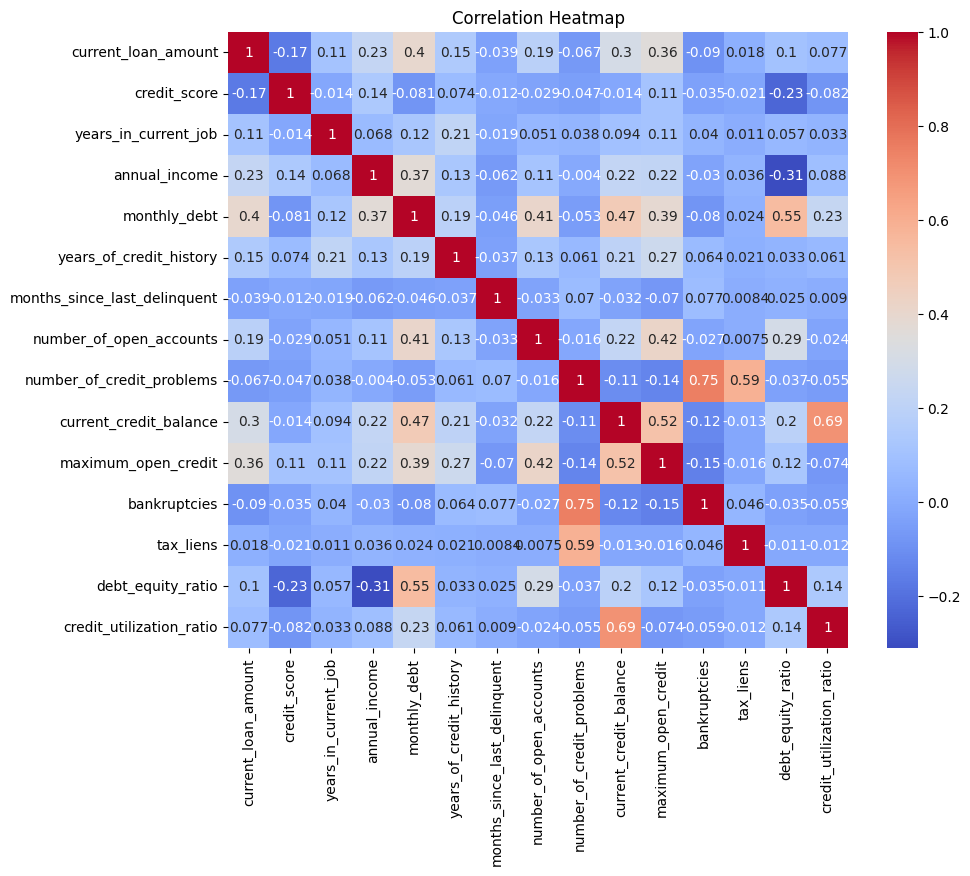

In [51]:
corr_matrix = df_feature[['current_loan_amount', 'credit_score', 'years_in_current_job', 'annual_income', 'monthly_debt', 'years_of_credit_history', 'months_since_last_delinquent', 'number_of_open_accounts', 'number_of_credit_problems', 'current_credit_balance', 'maximum_open_credit', 'bankruptcies', 'tax_liens', 'debt_equity_ratio', 'credit_utilization_ratio']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show();

As expected, there are several multicolinearity problems here. For this experiment, I will leave them be. Again, this is because I want to check whether I can sacrifice model interpretability for model performance scores. Often, the user doesn't really care whether I can interpret the model's prediction or not. So, if I can increase the scores significantly using all the features (both original and engineered features), I will choose the model with all the features. However, if I can't increase the score or the increase is not significant, I will use the model with no multicolinearity since it's easier to interpret. 

The next step is to standardize all the numeric columns except for the binary and ratio columns.

In [52]:
df_feature.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88298 entries, 0 to 88907
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   loan_status                   88298 non-null  object 
 1   current_loan_amount           88298 non-null  float64
 2   term                          88298 non-null  int64  
 3   credit_score                  88298 non-null  float64
 4   years_in_current_job          88298 non-null  float64
 5   home_ownership                88298 non-null  object 
 6   annual_income                 88298 non-null  float64
 7   purpose                       88298 non-null  object 
 8   monthly_debt                  88298 non-null  float64
 9   years_of_credit_history       88298 non-null  float64
 10  months_since_last_delinquent  88298 non-null  float64
 11  number_of_open_accounts       88298 non-null  int64  
 12  number_of_credit_problems     88298 non-null  int64  
 13  curren

In [53]:
cols_to_standardize = ['current_loan_amount', 'credit_score', 'annual_income', 'monthly_debt', 'years_of_credit_history', 'months_since_last_delinquent', 'number_of_open_accounts', 'number_of_credit_problems', 'current_credit_balance', 'maximum_open_credit', 'bankruptcies', 'tax_liens']
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_feature[cols_to_standardize].values)

data_temp = pd.DataFrame(data_scaled, columns=cols_to_standardize, index = df_feature.index)
df_feature[cols_to_standardize] = data_temp

In [55]:
df_feature.head()

,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,...,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens,debt_equity_ratio,credit_utilization_ratio,is_months_delinquent_missing,has_stable_job
0,loan_given,-0.328502,0,0.803701,4.0,rent,-0.554712,debt_consolidation,-0.958154,-0.967132,...,0.172482,-0.339374,0.096590,0.406314,-0.328764,-0.109704,0.007100,0.469000,0,1
1,loan_refused,1.268386,1,0.759013,6.0,rent,0.203041,business_loans,-0.664370,-0.101841,...,-0.833903,-0.339374,-0.070480,-0.492673,-0.328764,-0.109704,0.005684,0.833019,0,1
2,loan_given,0.574864,0,0.654741,3.0,home_mortgage,-0.308716,debt_consolidation,-0.600702,1.203189,...,-0.028795,-0.339374,-0.338518,-0.235532,-0.328764,-0.109704,0.009000,0.391000,0,1
3,loan_given,-0.312139,0,0.356820,10.0,own_home,-0.234559,debt_consolidation,-0.166690,1.699668,...,-0.833903,-0.339374,-0.283356,-0.490842,-0.328764,-0.109704,0.012417,0.585996,0,1
4,loan_given,-0.082064,0,-0.015582,1.0,own_home,-0.817285,personal_loans,-0.295251,-0.669245,...,0.172482,-0.339374,-0.448944,1.132311,-0.328764,-0.109704,0.022666,0.125996,0,0


In [54]:
#save the scaler
scaler_filename = 'model/scaler_all_features.pkl'
joblib.dump(scaler, scaler_filename)

['model/scaler_all_features.pkl']

Last thing to do in the preprocessing stage is to one-hot-encode "home_ownership" and "purpose" columns.

In [56]:
#create dummies variable (one hot encode)
dummies = pd.get_dummies(df_feature['purpose'], prefix='purpose', drop_first = True)
df_feature[dummies.columns] = dummies

dummies = pd.get_dummies(df_feature['home_ownership'], prefix='home', drop_first = True)
df_feature[dummies.columns] = dummies

df_feature = df_feature.drop(["home_ownership", "purpose"], axis=1)
df_feature = df_feature.replace({True: 1, False: 0})

In [57]:
df_feature.to_csv('data/final_data_all_features.csv', index = False)

In [61]:
h2o.cluster().shutdown()

H2O session _sid_9569 closed.


## Model Training
Here, I need to repeat some steps from the previous experiment, which is parsing the dataframe into H2O dataframe and dividing the dataframe into train, test, and val.

In [62]:
#restarting h2o server
h2o.init()

hf_all_features = h2o.H2OFrame(df_feature)

#separating predictors and response
predictors_af = list(df_feature.columns[1:])
response = "loan_status"

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.8+9-LTS-211, mixed mode, sharing)
  Starting server from C:\Users\agust\Anaconda3\envs\h2o_loan_classification\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\agust\AppData\Local\Temp\tmpm36tewpq
  JVM stdout: C:\Users\agust\AppData\Local\Temp\tmpm36tewpq\h2o_agust_started_from_python.out
  JVM stderr: C:\Users\agust\AppData\Local\Temp\tmpm36tewpq\h2o_agust_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Asia/Jakarta
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.2
H2O_cluster_version_age:,1 month and 19 days
H2O_cluster_name:,H2O_from_python_agust_5qg0g0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.854 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [63]:
#create train, test, and validation dataset
train_temp_af, test_af = hf_all_features.split_frame(ratios = [.8], seed = 42)
train_af, val_af = train_temp_af.split_frame(ratios = [.8], seed = 42)

### H2O Gradient Boosting Model
Similar to the previous experiment, I will use the helper function to train the gradient boosting model.

In [64]:
#hyperparameters to tune
learn_rate = [0.01, 0.05, 0.1]
max_depth = [5, 7, 9]
ntrees = [300, 500, 700]
sample_rate = [0.5, 0.8, 1.0]
col_sample_rate = [0.25, 0.5, 1.0]

#train the model
best_gbm_af, gbm_perf_af, gbm_gridperf_af = helper.train_gbm_h2o(predictors_af, response, train_af, test_af, val_af, learn_rate, max_depth, ntrees, sample_rate, col_sample_rate)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


In [65]:
gbm_gridperf_af

,col_sample_rate,learn_rate,max_depth,ntrees,sample_rate,model_ids,aucpr
,1.0,0.05,7.0,300.0,0.8,gbm_grid1_model_96,0.4723157
,0.5,0.01,9.0,700.0,0.5,gbm_grid1_model_74,0.4721133
,1.0,0.01,7.0,700.0,0.5,gbm_grid1_model_66,0.4719734
,1.0,0.05,5.0,700.0,0.8,gbm_grid1_model_141,0.4719572
,1.0,0.05,5.0,300.0,0.5,gbm_grid1_model_6,0.4718498
,0.5,0.05,5.0,500.0,0.8,gbm_grid1_model_113,0.4718229
,1.0,0.01,9.0,700.0,0.8,gbm_grid1_model_156,0.4717810
,1.0,0.05,5.0,500.0,0.5,gbm_grid1_model_33,0.4717438
,1.0,0.05,5.0,500.0,0.8,gbm_grid1_model_114,0.4717289
,1.0,0.01,7.0,700.0,0.8,gbm_grid1_model_147,0.4717230


In [66]:
print(gbm_perf_af)

ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.182987902604885
RMSE: 0.42777085291647093
LogLoss: 0.5451574784290131
Mean Per-Class Error: 0.36606071162850773
AUC: 0.6903680024717357
AUCPR: 0.4803279677319608
Gini: 0.3807360049434714

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2429933788806691
              loan_given    loan_refused    Error    Rate
------------  ------------  --------------  -------  ----------------
loan_given    6825          5858            0.4619   (5858.0/12683.0)
loan_refused  1355          3659            0.2702   (1355.0/5014.0)
Total         8180          9517            0.4076   (7213.0/17697.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.242993     0.503613  259
max f2                       0.135358     0.678246  339
max f0point5                 0.36746      0.46178

#### Model Summary
The model summary is as follows:

In [69]:
f1_gbm_af, precision_gbm_af, recall_gbm_af, auc_gbm_af = helper.calculate_metrics_summary(gbm_perf_af, df_feature, 'GBM')

The F1 score for GBM is 0.7284706965627562
The precision score for GBM is 0.9874599461673628
The recall score for GBM is 0.7226935078006457
The AUC score for GBM is 0.6903680024717357


The key takeaways from the model summary are:
1. The F1 score indicates that the model can achieve a somewhat good balance between making correct positive predictions and capturing positive instances. 
2. Based on the precision score, this model is able to predict 71.39% approved loans when the loans are supposed to be approved. This is a good score for the model.
3. Based on the recall score, this model can recognize 73.6% of all eligible loan applicants. Although this number is considerably good, this means that the business has the chance of losing 27.28% eligible loan applicants.
4. The AUC score indicates that the model's power to discriminate between positive and negative cases (loan given and loan refused) not too good. It's too close to 0.5 which indicates that the model is closer to a random guess than an accurate prediction.

In [70]:
#saving model
model_path = h2o.save_model(
  best_gbm_af,
  path = "model",
  force = True,
  export_cross_validation_predictions = False
)
model_path

'C:\\Online Course\\Projects\\loan-classification-h20-xgboost\\model\\gbm_grid1_model_96'

### Using H2O Deep Learning 
Similar to the previous experiment, I will use the helper function to train the deep learning model.

In [71]:
best_dl_model_af, dl_perf_af = helper.train_dl_h2o(predictors_af, response, train_af, test_af, val_af, hidden, epochs, balance_classes, activation)

deeplearning Grid Build progress: |██████████████████████████████████████████████| (done) 100%


In [72]:
print(dl_perf_af)

ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.1857448774213884
RMSE: 0.43098129590666506
LogLoss: 0.5537266748033468
Mean Per-Class Error: 0.38668435783417565
AUC: 0.6769308335147749
AUCPR: 0.47035100862085977
Gini: 0.3538616670295498

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21459508308080927
              loan_given    loan_refused    Error    Rate
------------  ------------  --------------  -------  ----------------
loan_given    5414          7269            0.5731   (7269.0/12683.0)
loan_refused  1004          4010            0.2002   (1004.0/5014.0)
Total         6418          11279           0.4675   (8273.0/17697.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.214595     0.492236  277
max f2                       0.0906327    0.675399  356
max f0point5                 0.377179

#### Model Summary
The model summary is as follows:

In [74]:
f1_dl_af, precision_dl_af, recall_dl_af, auc_dl_af = helper.calculate_metrics_summary(dl_perf_af, df_feature, 'Deep Learning')

The F1 score for Deep Learning is 0.7180022370137817
The precision score for Deep Learning is 0.995540417177498
The recall score for Deep Learning is 0.7173291044787228
The AUC score for Deep Learning is 0.6769308335147749


The key takeaways from the model summary are:
1. The F1 score indicates that the model can achieve a somewhat good balance between making correct positive predictions and capturing positive instances. 
2. Based on the precision score, this model is able to predict 71.39% approved loans when the loans are supposed to be approved. This is a good score for the model.
3. Based on the recall score, this model can recognize 73.6% of all eligible loan applicants. Although this number is considerably good, this means that the business has the chance of losing 27.28% eligible loan applicants.
4. The AUC score indicates that the model's power to discriminate between positive and negative cases (loan given and loan refused) not too good. It's too close to 0.5 which indicates that the model is closer to a random guess than an accurate prediction.

In [75]:
#saving model
model_path = h2o.save_model(
  best_dl_model_af,
  path = "model",
  force = True,
  export_cross_validation_predictions = False
)
model_path

'C:\\Online Course\\Projects\\loan-classification-h20-xgboost\\model\\dl_grid_model_1'

### Using XGBoost
Similar to the previous experiment, I will use the helper function to train the XGBoost model.

In [77]:
best_xgb_model_af, X_test_af, y_test_af = helper.train_xgboost(df_feature, n_estimators, max_depth, subsample, reg_alpha, reg_lambda, learning_rate, max_bin)

The number of training dataset is 56510, the number of validation dataset is 14128, and the number of testing dataset is 17660.
Training the model...
Fitting 3 folds for each of 1458 candidates, totalling 4374 fits
DONE!
Best Parameters: {'learning_rate': 0.1, 'max_bin': 128, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0.5, 'reg_lambda': 0.1, 'subsample': 0.8}


#### Model Summary
The model summary is as follows:

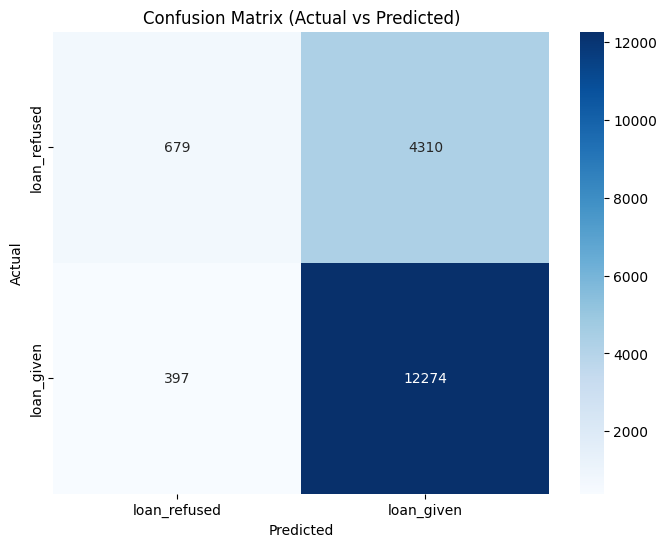

The F1 score for XGBoost is 0.6653096002117962
The precision score for XGBoost is 0.7092983500892115
The recall score for XGBoost is 0.7334654586636467
The AUC score for XGBoost is 0.5523840160451485


In [79]:
f1_xgb_af, precision_xgb_af, recall_xgb_af, auc_xgb_af = calculate_model_metrics_xgboost(best_xgb_model_af, X_test_af, y_test_af, "XGBoost")

The key takeaways from the model summary are:
1. The F1 score indicates that the model can achieve a somewhat good balance between making correct positive predictions and capturing positive instances. 
2. Based on the precision score, this model is able to predict 70.92% approved loans when the loans are supposed to be approved. This is a good score for the model.
3. Based on the recall score, this model can recognize 73.34% of all eligible loan applicants. .
4. The AUC score indicates that the model's power to discriminate between positive and negative cases (loan given and loan refused) not too good. It's too close to 0.5 which indicates that the model is closer to a random guess than an accurate prediction.
5. All the scores are lower compared to the base model.

In [80]:
joblib.dump(best_xgb_model_af, 'model/best_xgb_model_all_features.pkl')

['model/best_xgb_model_all_features.pkl']

### Comparisons between 3 models

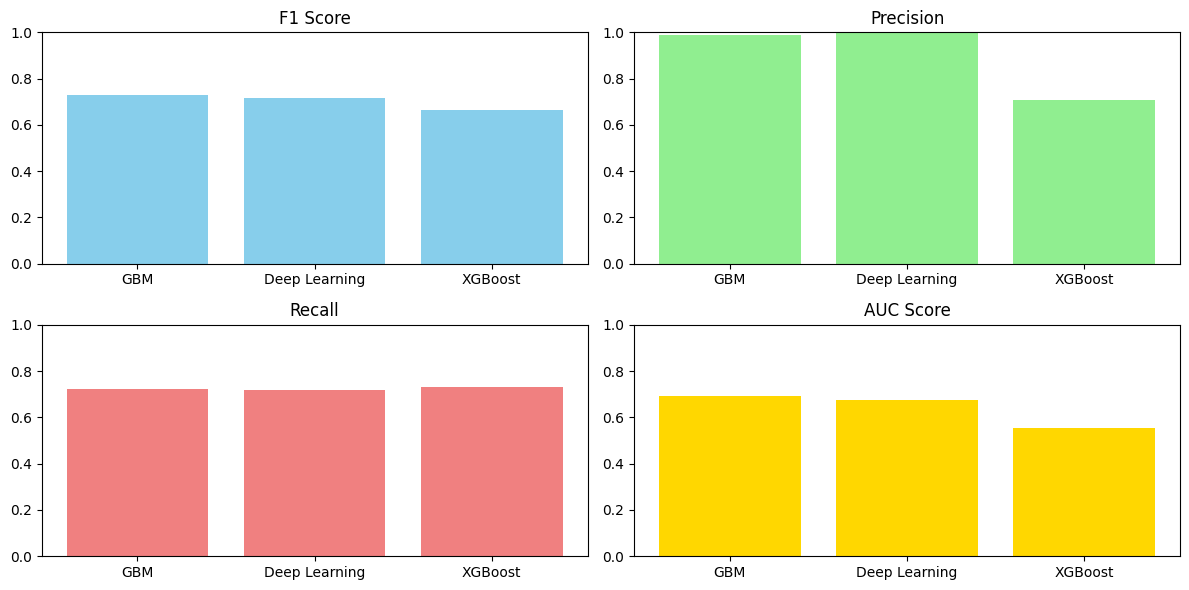

In [81]:
models = ['GBM', 'Deep Learning', 'XGBoost']
f1_scores_af = [f1_gbm_af, f1_dl_af, f1_xgb_af]
precision_scores_af = [precision_gbm_af, precision_dl_af, precision_xgb_af]
recall_scores_af = [recall_gbm_af, recall_dl_af, recall_xgb_af]
auc_scores_af = [auc_gbm_af, auc_dl_af, auc_xgb_af]
scores_df_af = helper.compare_score(f1_scores_af, precision_scores_af, recall_scores_af, auc_scores_af, models)

In [82]:
scores_df_af

,Model,F1 Score,Precision,Recall,AUC Score
0,GBM,0.728471,0.987460,0.722694,0.690368
1,Deep Learning,0.718002,0.995540,0.717329,0.676931
2,XGBoost,0.665310,0.709298,0.733465,0.552384


In [83]:
scores_df_af.to_csv('data/all_features_model_scores.csv', index = False)

## Selecting the best model

In [85]:
base_scores_df = pd.read_csv('data/base_model_scores.csv')
base_scores_df

,Model,F1 Score,Precision,Recall,AUC Score
0,GBM,0.736870,0.982921,0.727268,0.691829
1,Deep Learning,0.739197,0.998454,0.728502,0.678001
2,XGBoost,0.674320,0.713955,0.736025,0.562727


In [86]:
scores_df

,Model,F1 Score,Precision,Recall,AUC Score
0,GBM,0.738735,0.983804,0.728170,0.675995
1,Deep Learning,0.766211,0.926749,0.744745,0.661148
2,XGBoost,0.660028,0.704767,0.731200,0.547342


In [87]:
scores_df_af

,Model,F1 Score,Precision,Recall,AUC Score
0,GBM,0.728471,0.987460,0.722694,0.690368
1,Deep Learning,0.718002,0.995540,0.717329,0.676931
2,XGBoost,0.665310,0.709298,0.733465,0.552384


The resulting base models and models generated from the experiments are a bit mixed. However, it's obvious that the models from the experiment with both original and engineered features included perform worse than the base model and the one with no multicolinearity.

The best AUC scores are generated from the base models, with the highest being the base GBM model. However, the GBM model with no multicolinearity holds the best precision score. In terms of scores, this model outperforms the best GBM model apart from the AUC score. The deep learning model with no multicolinearity has the best F1 and recall scores. However, although the precision score is quite high, it dropped from the base deep learning model.

For me, the best model I have to choose depends on the requirements of the user. If the user demands a high precision score, I will go with the GBM model with no multicolinearity. If the user wants the highest recall or F1 score, I will go with the deep learning model with no multicolinearity. If the concern is the AUC score, I will go with the base GBM model.

For this project, I choose the deep learning model with no multicolinearity (dl_grid_model_66) since in general, it performs quite well. Although I have to sacrifice the precision and AUC scores. The model explainability are as follows: 

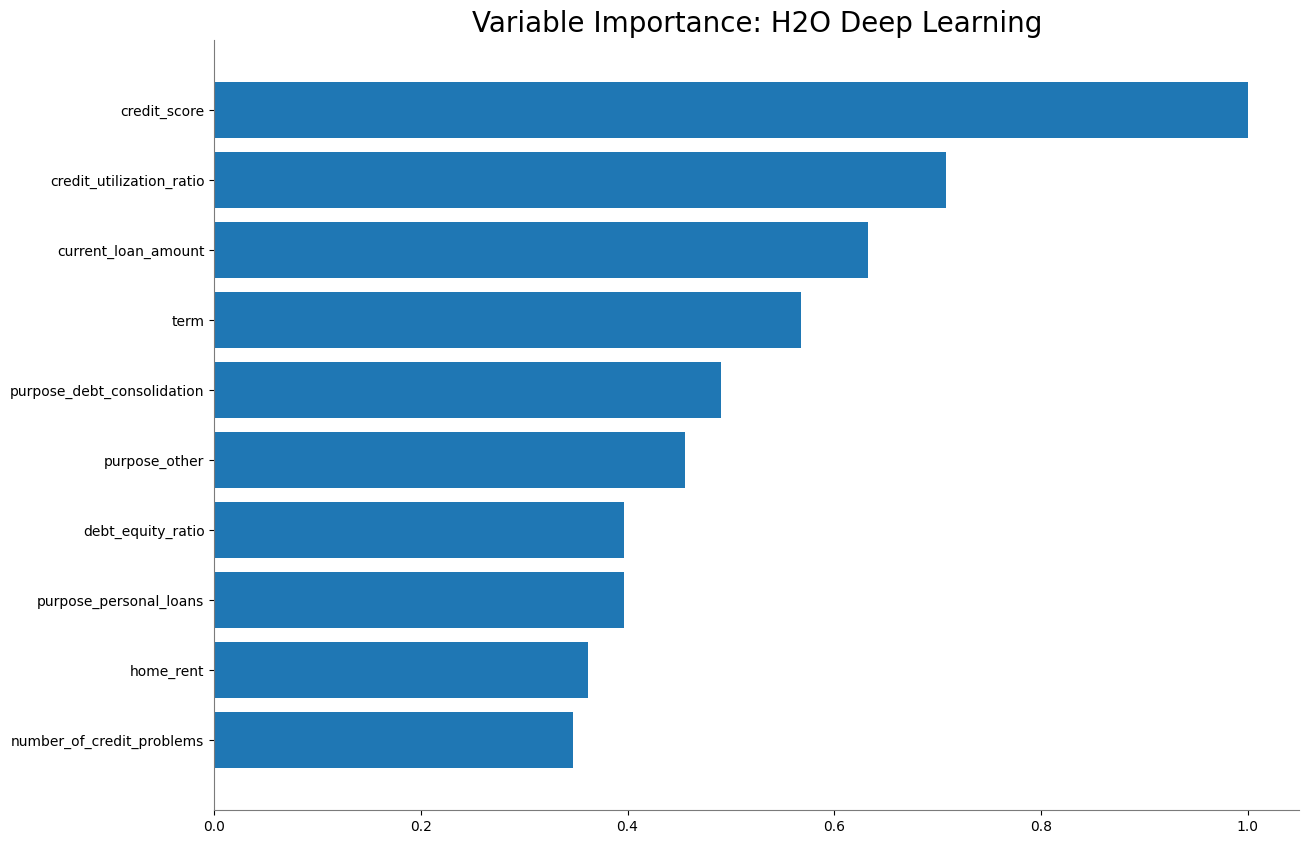

<Figure size 640x480 with 0 Axes>

In [31]:
best_dl_model.varimp_plot()

The barchart indicates that the top 3 most important features are credit_score, credit_utilization_ratio, and current_loan_amount. They affect the model's prediction the most. It has to be noted, however, that deep learning models are considerable more chalenging to interpret. For this model, as far as I know, the H2O varimp plot works better with tree-based model compared to deep learning model. If I need to interpret this model well, I might need to create it from scratch using tensorflow or pytorch, and use SHAP vales or Grad-cam techniques to do so.

## Conclusion
From these 2 experiments, I was able to get the best model to make predictions. Since this is just a project with the aim to hone my skills, I limit the experiments into 2 because training the models take a long time. Usually, I try to get the scores as high as possible by getting new data, engineer more features, or mix-and-match the features. For example, I might do more experiments by using the engineered features and bankruptcies, the engineered features with tax_liens, or the engineered features with both. And I will strive to get the demographic features (such as age, sex, location, type of jobs, etc.) from the data engineers and create more features based on that. 

Usually, I select the best model based on the task requirements. Some might want to have the highest precision so that the user is confident that the loans given to applicants will be paid, and some might want to have the highest recall so that the chance of losing business is the lowest. For this project, I choose the deep learning model with no multicolinearity since in general, it performs well.

In the next notebook, I will create a prediction pipeline for the model. However, I will first deploy the model using FastAPI since this is not that big of a model. Then, I will build the pipeline for the prediction, accounting for any feature I created in this notebook.